# Variable selection

This notebook contains the code, results, and interpretation of unsupervised and supervised variable selection techniques of radiomic features extracted from simulation CT scans of a cohort of 49 patients with locally advanced rectal cancer. The purpose is to predict the pathological response to neoadjuvant chemoradioterapy.


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
## For PCA
from sklearn.decomposition import PCA
## For Logistic regression
from sklearn.linear_model import LogisticRegression
## For Random Forest
from sklearn.ensemble import RandomForestClassifier

## Data reading

In [2]:
# Read the data
radiomics = pd.read_excel('data/caracteristicas_radiomicas.xlsx')
clinic = pd.read_excel('data/caracteristicas_clinicas.xlsx')

# Remove outliers
radiomics = radiomics.drop([2,6])
clinic = clinic.drop([2,6])

# Retrieve response
response = clinic['Respuesta_patologica'].map({'Completa': 0,
                                               'Parcial': 1,
                                               'Estable': 1,
                                               'Progresion': 1})

# Make clinic variables numeric (and remove useless ones)
clinic['Genero'] = clinic['Genero'].map({'Hombre': 0, 'Mujer': 1})
clinic['Localización'] = pd.cut(clinic['Localización'], [0, 5, 10, 100],
                                labels=[0, 1, 2])
clinic = clinic.drop(['T_clinico'], axis=1) # {'T3': 43, 'T4': 2, 'T2': 2, 'T4b': 1, 'T4a': 1} NO USAR
clinic['N_clinico'] = clinic['N_clinico'].map({'N0': 0, 'N1a': 1, 'N1b': 1,
                                               'N2a': 2, 'N2b':2})
clinic = clinic.drop(['M_clinico'], axis=1)  # constante
clinic = clinic.drop(['Etapa_TNM'], axis=1)  # {'IIIB': 32, 'IIIC': 8, 'IIA': 7, 'IIIA': 2} NO USAR
clinic['Invasion_mesorecto'] = clinic['Invasion_mesorecto'].map({'No': 0,
                                                                 'Grasa': 1,
                                                                 'Fascia': 1})
clinic['CEA_basal'] = pd.cut(clinic['CEA_basal'], [-1, 5, 1000],
                             labels=[0, 1])


The two datasets contained 50 cases, of which cases 2 and 6 were identified as outliers and were therefore removed. Regarding the clinical variables dataset, it is important to note that the variables `T_clinico` and `Etapa_TNM` had to be removed due to significant class imbalance. Additionally, the variable `M_clinico` was eliminated because it was a constant. Finally, the variables `Localización` and `CEA_basal` were categorized according to clinical stablished thresholds. Moreover, to avoid an excessive number of categories, the variable `N_clinico` was regrouped: `N0`, `N1a` and `N1b` were combined into one category, while `N2a` y `N2b`, were combined into another.


## Variable Selection with PCA

First, a principal component analysis (PCA) was used for variable selection. This method, being an unsupervised clustering method, groups cases in a multidimensional space according to their similarity.


In [3]:
# scale features
scaler = StandardScaler()
radiomics_scaled = scaler.fit_transform(radiomics.iloc[:,1:])
radiomics_scaled = pd.DataFrame(radiomics_scaled,
                                columns=radiomics.columns[1:])

# PCA
pca = PCA(n_components=5)
pca_fit = pca.fit_transform(radiomics_scaled)
pca_fit_df = pd.DataFrame(data = pca_fit,
                          columns = ['principal component 1',
                                     'principal component 2',
                                     'principal component 3',
                                     'principal component 4',
                                     'principal component 5'])
pca_fit_df['response'] = response

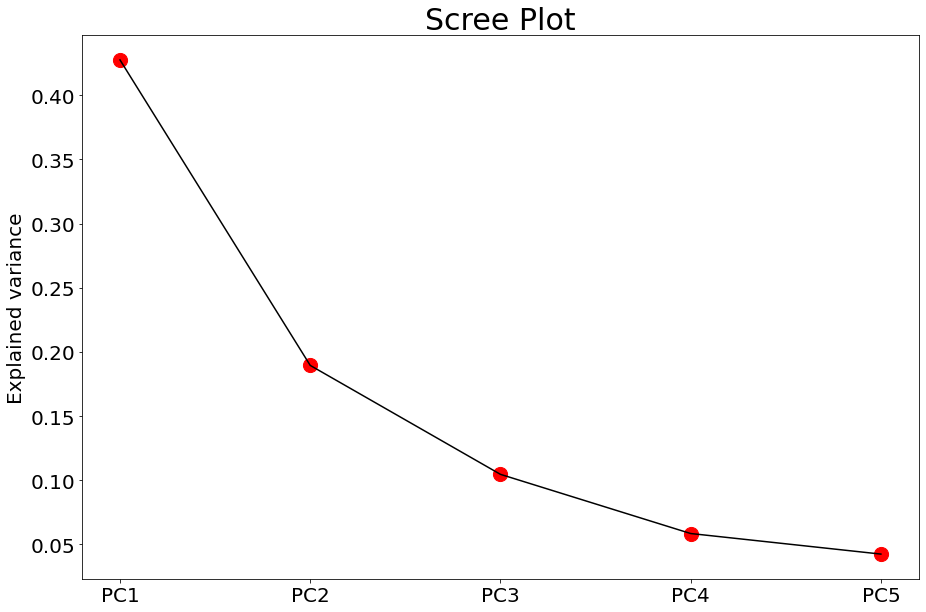

In [4]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(np.arange(len(pca.explained_variance_ratio_)),
            pca.explained_variance_ratio_, color='red', s=200)
plt.plot(np.arange(len(pca.explained_variance_ratio_)),
         pca.explained_variance_ratio_, color='black')
plt.xticks(np.arange(len(pca.explained_variance_ratio_)),
           ['PC'+str(i) for i in range(1,6)], fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Explained variance', fontsize=20)
plt.title('Scree Plot',fontsize=30)
plt.show()


According to the percentage of explained variance and following the elbow method, only the first principal component is selected as the one that sufficiently summarizes the variability of the data.


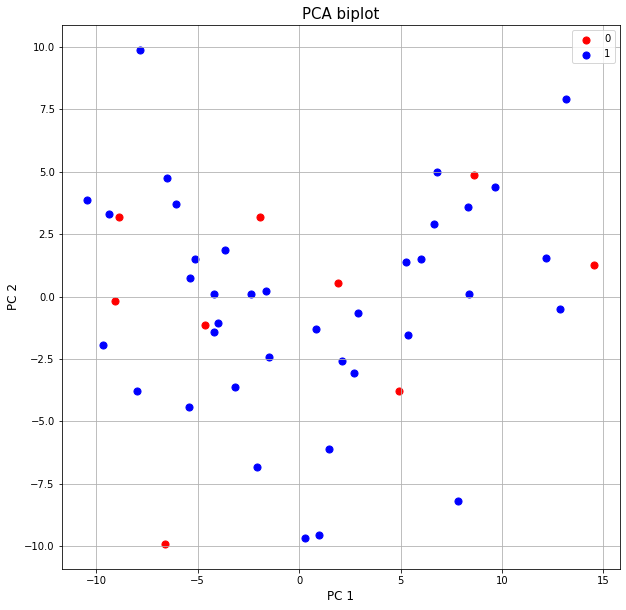

In [5]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1', fontsize = 12)
ax.set_ylabel('PC 2', fontsize = 12)
ax.set_title('PCA biplot', fontsize = 15)
diags=[0,1]
colors=['r','b']
for diag, color in zip(diags,colors):
    i = pca_fit_df['response'] == diag
    ax.scatter(pca_fit_df.loc[i, 'principal component 1']
               , pca_fit_df.loc[i, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(diags)
ax.grid()


In the multidimensional space generated by the PCA, it becomes evident that neither of the two categories is clearly differentiated.


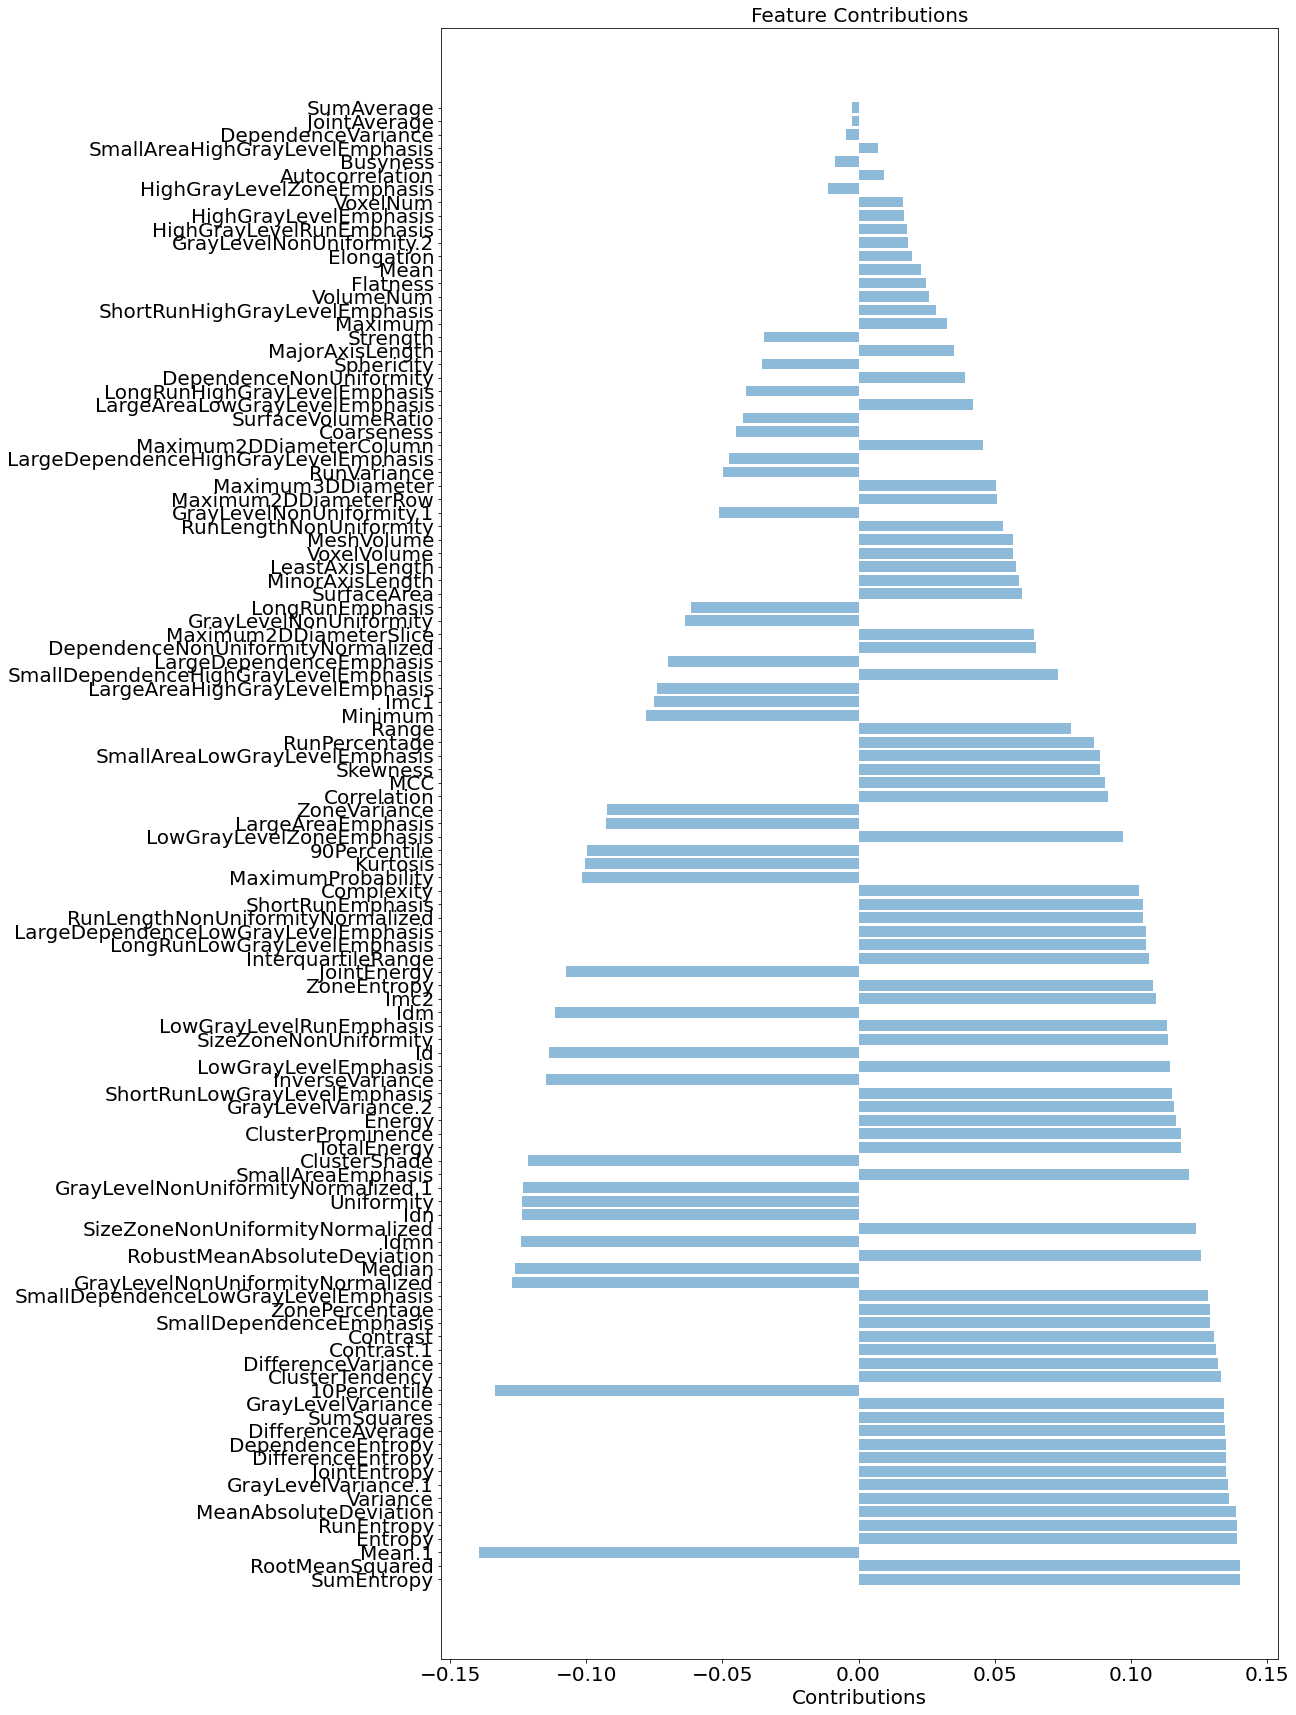

In [6]:
pca_comp = pd.DataFrame({'PC1': pca.components_[0],
                         'PC1_abs': np.abs(pca.components_[0]),
                         'feature': radiomics_scaled.columns})
pca_comp = pca_comp.sort_values('PC1_abs', ascending=False)
fig, ax = plt.subplots(figsize=(15, 30))
plt.barh(np.arange(len(pca_comp.index)), pca_comp['PC1'], align='center', alpha=0.5)
plt.yticks(np.arange(len(pca_comp.index)), pca_comp['feature'], fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Contributions', fontsize=20)
plt.title('Feature Contributions',fontsize=20)
plt.show()


The previous figure shows the contribution of the variables to the first principal component, indicating that many of them effectively contribute to the clustering of the data. Among them, the 15 most important (ranked by contribution weight) are:


In [7]:
pca_comp['feature'][0:15]

57               SumEntropy
30          RootMeanSquared
25                   Mean.1
20                  Entropy
81               RunEntropy
24    MeanAbsoluteDeviation
34                 Variance
75      GrayLevelVariance.1
53             JointEntropy
42        DifferenceEntropy
59        DependenceEntropy
41        DifferenceAverage
58               SumSquares
64        GrayLevelVariance
17             10Percentile
Name: feature, dtype: object

## Selection through Logistic Regression

Given that PCA does not appear to be an effective technique for separating patients based on radiomic variables, a supervised technique like logistic regression is chosen instead. This technique aims to find the best linear relationship among the variables to predict the response variable.


In [8]:
# Ajuste del modelo
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(radiomics_scaled, response)

# Obtención de los coeficientes (~pesos) de las variables
Weights=pd.DataFrame({'wght': np.hstack((model.intercept_[:,None], model.coef_))[0][1:],
                      'feature': radiomics_scaled.columns})
Weights['wght_abs'] = np.abs(Weights['wght'])
Weights = Weights.sort_values('wght_abs', ascending=False)

# Accuracy de test del modelo 
predicciones = model.predict(radiomics_scaled)
clasificacion = np.where(predicciones<0.5, 0, 1)
accuracy = accuracy_score(
            y_true    = response,
            y_pred    = clasificacion,
            normalize = True
           )
print("")
print(f"El accuracy de test es: {100*accuracy}%")


El accuracy de test es: 95.91836734693877%


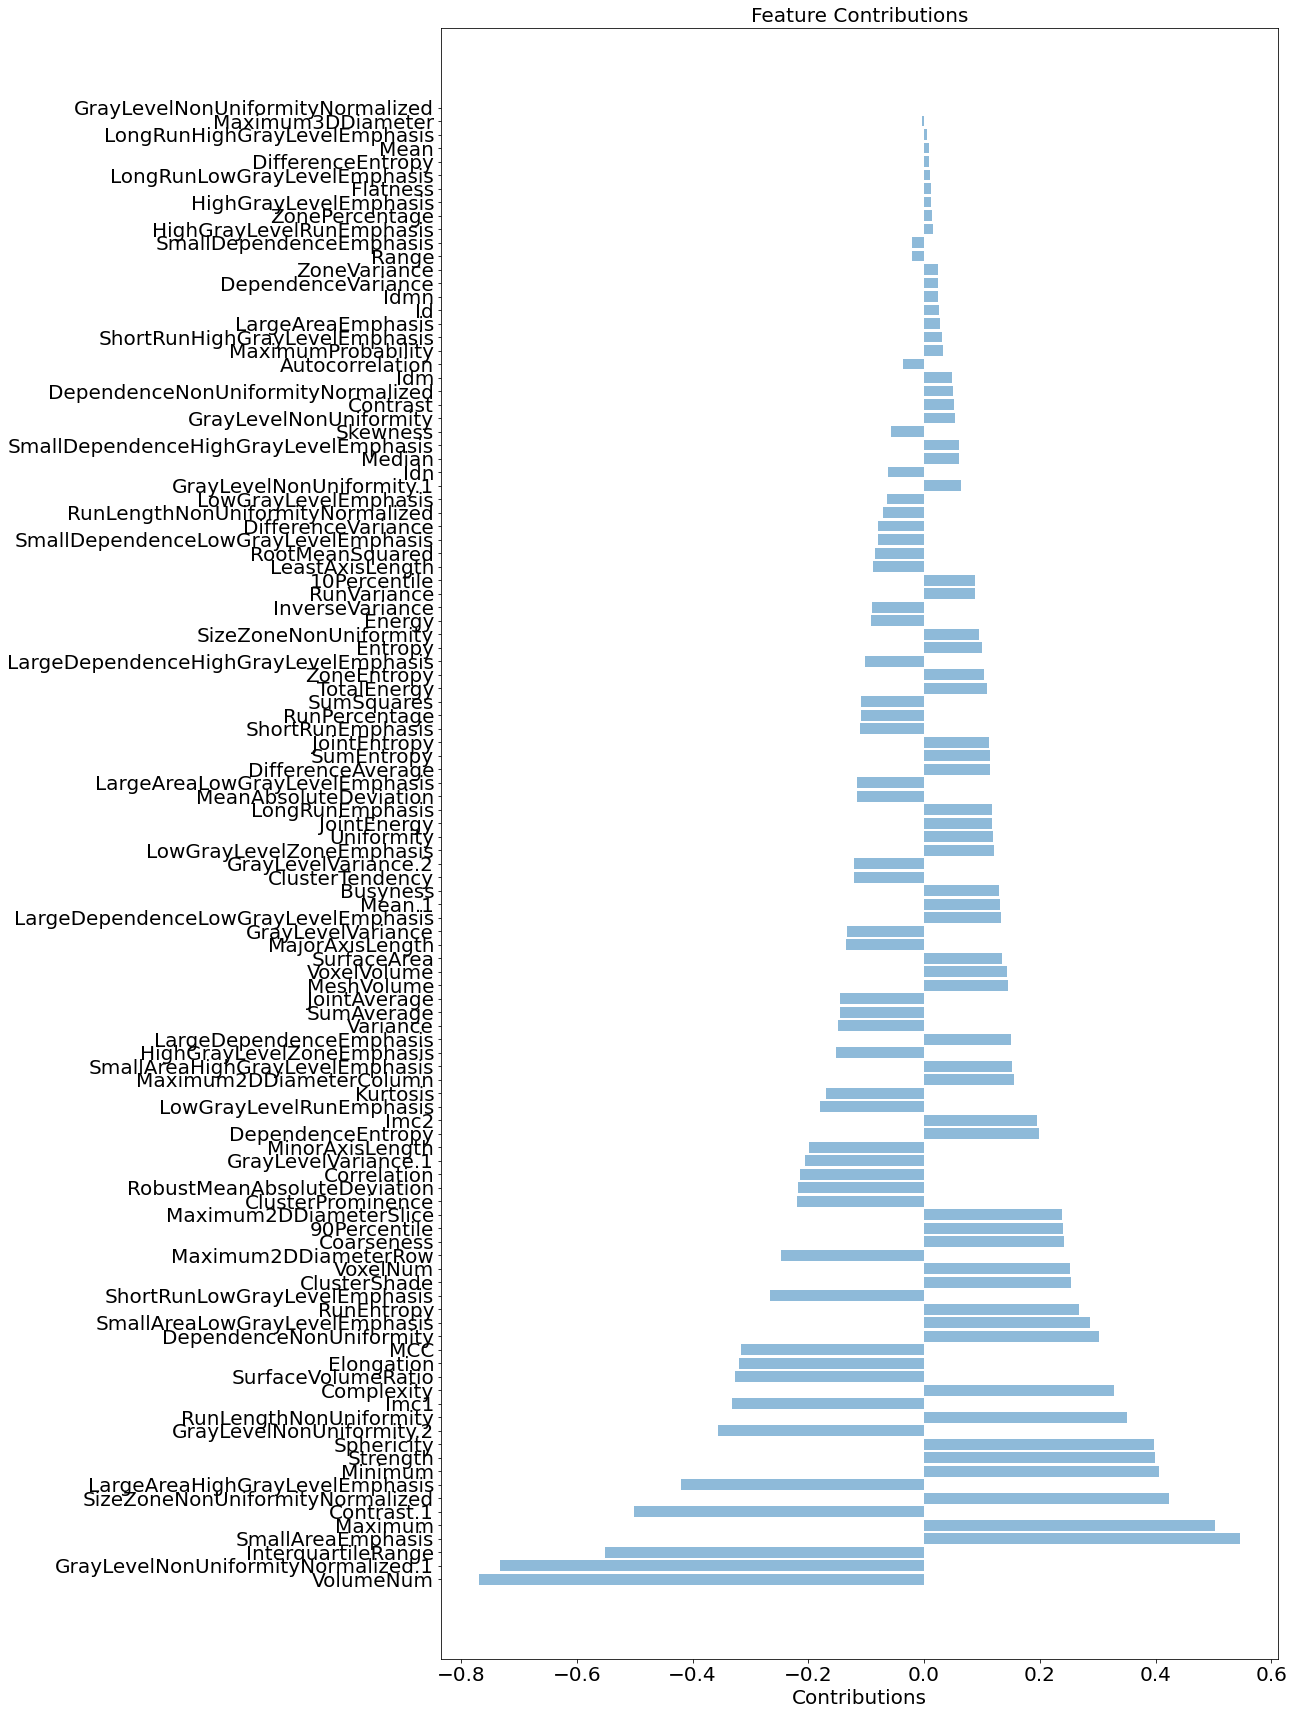

In [9]:
fig, ax = plt.subplots(figsize=(15, 30))
plt.barh(np.arange(len(Weights.index)), Weights['wght'], align='center', alpha=0.5)
plt.yticks(np.arange(len(Weights.index)), Weights['feature'], fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Contributions', fontsize=20)
plt.title('Feature Contributions',fontsize=20)
plt.show()


The figure shows the variables ranked by their coefficients, highlighting that two variables contribute significantly more than the others. In this case, the 15 variables that contribute the most to the separation of the two response categories are:


In [10]:
Weights['feature'][0:15]

2                               VolumeNum
90     GrayLevelNonUniformityNormalized.1
21                     InterquartileRange
99                      SmallAreaEmphasis
23                                Maximum
108                            Contrast.1
98        SizeZoneNonUniformityNormalized
94         LargeAreaHighGrayLevelEmphasis
27                                Minimum
109                              Strength
13                             Sphericity
89               GrayLevelNonUniformity.2
82                 RunLengthNonUniformity
48                                   Imc1
107                            Complexity
Name: feature, dtype: object

## Selection through Random Forest

The high accuracy of the logistic regression model might 
indicate issues of overfitting. This is expected given the 
large number of variables included for only 50 cases. 
For this reason, and as a complementary approach, random 
forest is also used with all radiomic features. 
This method allows for the selection of variables based 
on their importance within the model.


In [11]:
rf = RandomForestClassifier()
rf.fit(radiomics_scaled, response)

# Get importances
feature_importances = pd.Series(rf.feature_importances_,
                                index=radiomics_scaled.columns).sort_values(ascending=False)

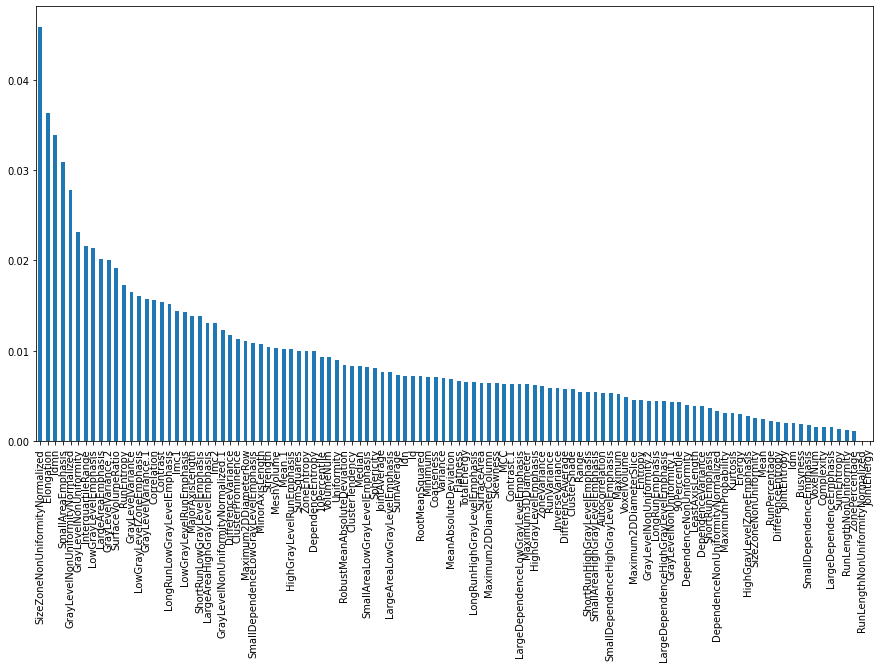

In [12]:
# Plot a simple bar chart
fig, ax = plt.subplots(figsize=(15, 8))
feature_importances.plot.bar()
plt.show()

In this case, it can be observed that one variable stands out significantly in its contribution to the separation of the response variable. For the random forest, the 15 most important variables are:

In [13]:
feature_importances[0:15]

SizeZoneNonUniformityNormalized     0.045844
Elongation                          0.036358
Idmn                                0.033922
SmallAreaEmphasis                   0.030911
GrayLevelNonUniformityNormalized    0.027795
GrayLevelNonUniformity              0.023120
InterquartileRange                  0.021638
LowGrayLevelEmphasis                0.021337
LargeAreaEmphasis                   0.020151
GrayLevelVariance.2                 0.020108
SurfaceVolumeRatio                  0.019162
RunEntropy                          0.017250
GrayLevelVariance                   0.016549
LowGrayLevelZoneEmphasis            0.016042
GrayLevelVariance.1                 0.015715
dtype: float64

## Final Variable Selection

Given the discrepancy in the variables selected by both methods, the decision made was to select those common to both methods. Additionally, the two most important variables from logistic regression and the most important one from random forest will also be included. So, the radiomic variables selected for the rest of the analysis are:

In [14]:
best_rl = Weights.feature[0:20].tolist()
best_rf = feature_importances.index[0:20].tolist()
best_common = set(best_rl[2:]) & set(best_rf[1:])

selected_vars = [best_rl[0:2], best_rf[0], best_common]
selected_vars

[['VolumeNum', 'GrayLevelNonUniformityNormalized.1'],
 'SizeZoneNonUniformityNormalized',
 {'Elongation',
  'Imc1',
  'InterquartileRange',
  'SmallAreaEmphasis',
  'SurfaceVolumeRatio'}]

In [15]:
# Selected variables
clinic = clinic.drop(['ID', 'Respuesta_patologica'], axis=1)
radiomics = radiomics[['VolumeNum', 'GrayLevelNonUniformityNormalized.1',
                       'Elongation', 'InterquartileRange',
                       'SizeZoneNonUniformityNormalized', 'SmallAreaEmphasis',
                       'Strength', 'SurfaceVolumeRatio']]
df = pd.concat([radiomics.reset_index(drop=True),
                clinic.reset_index(drop=True)],
               axis=1)
df['response'] = response.reset_index(drop = True)
df.to_csv("data/selected_features.csv", index = False)
df.head()

,VolumeNum,GrayLevelNonUniformityNormalized.1,Elongation,InterquartileRange,SizeZoneNonUniformityNormalized,SmallAreaEmphasis,Strength,SurfaceVolumeRatio,Edad,Genero,Localización,N_clinico,Invasion_mesorecto,CEA_basal,response
0,1,0.026988,0.511936,197.0,0.444987,0.693348,0.882716,0.134019,64,0,0,1,1,0,1
1,1,0.061615,0.700567,111.0,0.328651,0.592024,1.579438,0.145663,72,0,1,2,1,0,1
2,1,0.043117,0.728945,97.0,0.397054,0.654634,2.444571,0.133402,68,0,0,1,0,1,1
3,1,0.026388,0.861587,802.0,0.541238,0.763957,0.398438,0.097681,65,0,1,0,0,0,0
4,1,0.032382,0.776489,111.0,0.436163,0.686958,0.987403,0.119279,72,1,1,1,0,0,1
